# Import Dependencies

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data Loading

In [2]:
train_data = pd.read_csv("data/train.csv")
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [3]:
# Count number of rows and columns
rows, cols = train_data.shape

print(f"Number of rows: {rows:,}")
print(f"Number of columns: {cols}")

Number of rows: 1,458,644
Number of columns: 11


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


# Data Cleaning

## Summary of Findings

**Duplicate Records**
- There are no duplicated rows.

**Irrelevant Features**
- `id` is not needed as this is just an identifier and should not have any predictive power.
- `dropoff_datetime` should not be included because this feature is not available at prediction time and contains future information that can cause data leakage (hence why it is also not present in the test set).
- `store_and_fwd_flag` does not really hold any meaningful data relating to the trip duration. Additionally, it has extremely low variance, with 99% of the data containing a value of `N`. So, it's safe to remove this feature to also minimize noise.

**Incorrect Data Types**
- `vendor_id` should be converted to `category` type.
- `pickup_datetime` should be `datetime`.

**Missing Values**
- There are no missing values across all columns.

**Invalid / Out of Range Values**
- `passenger_count` has values of `0` (no passengers) and reaches as high as 9 passengers, which is unrealistic for the capacity of a taxi in NYC. Thus, records with no passengers or counts greater than 5 will be excluded to reflect reality.
- `trip_duration` has both too low (1 second) and too high (900+ hours) duration values. 

**Outliers**
- c


## Identifying Data Issues

### Duplicates

In [6]:
# Check for duplicates
num_duplicates = train_data.duplicated().sum()
print(f"Number of duplicate records: {num_duplicates}")

Number of duplicate records: 0


### Irrelevant Features

In [7]:
# Check if `store_and_fwd_flag` has low variance
train_data.value_counts("store_and_fwd_flag", normalize=True)

store_and_fwd_flag
N    0.994485
Y    0.005515
Name: proportion, dtype: float64

Since the vast majority (99%) of records contain the value `N` for `store_and_fwd_flag`, this shows that the feature has extremely low variance. This means that the column can be safely dropped because the low variance would cause the feature to have low predictive power and may just introduce noise to the data.

### Missing Values

In [8]:
# Check for missing data
print("Missing values per column:")
print(train_data.isna().sum())

Missing values per column:
id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


### Invalid / Out of Range Values

In [9]:
# Check for invalid/inconsistent categories
train_data["vendor_id"].unique().tolist()


[2, 1]

The categories in `vendor_id` are as expected (two taxi vendors), so no inconsistent values exist here.

In [10]:
# Check for suspicious passenger counts
train_data["passenger_count"].apply(["min", "max"])

min    0
max    9
Name: passenger_count, dtype: int64

According to [NYC.gov](https://www.nyc.gov/site/tlc/passengers/passenger-frequently-asked-questions.page), The max limit of an NYC taxi should be 5 passengers. So, passenger counts greater than this should be removed to reflect reality.

Additionally, records with a passenger count of 0 will also be removed as a taxi trip should have at least one passenger.

In [11]:
# Count how many rows are affected
unrealistic_passengers = len(train_data[(train_data["passenger_count"] == 0) | (train_data["passenger_count"] > 5)])

print(f"Number of rows affected: {unrealistic_passengers:,}")
print(f"Proportion of data: {unrealistic_passengers / len(train_data) * 100:.2f}%")

Number of rows affected: 48,398
Proportion of data: 3.32%


In [12]:
# Check for suspicious trip durations
trip_times_converted = pd.DataFrame({
    "duration_secs": train_data["trip_duration"],
    "duration_mins": train_data["trip_duration"] / 60,
    "duration_hrs": train_data["trip_duration"] / 3600 
})

trip_times_converted.describe().loc[['min', '25%', '50%', '75%', 'max']]

,duration_secs,duration_mins,duration_hrs
min,1.0,0.016667,0.000278
25%,397.0,6.616667,0.110278
50%,662.0,11.033333,0.183889
75%,1075.0,17.916667,0.298611
max,3526282.0,58771.366667,979.522778


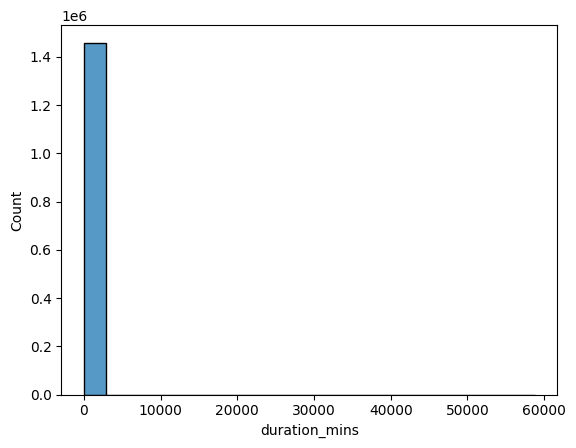

In [19]:
sns.histplot(data=trip_times_converted, x="duration_mins", bins=20)
plt.show()

The trip durations have very short (1 second) and extremely long (~978 hours) duration values, which are far too unrealistic. As reflected in the histogram above, this causes severely skewed data, which can negatively impact model performance.

Thus, records with unrealistic durations will be excluded. For this context, the reasonable minimum duration is 1 minute (60 seconds) while the max duration should be 2 hours (7200 seconds). So, only records that fit in this range will be included in the cleaned dataset.

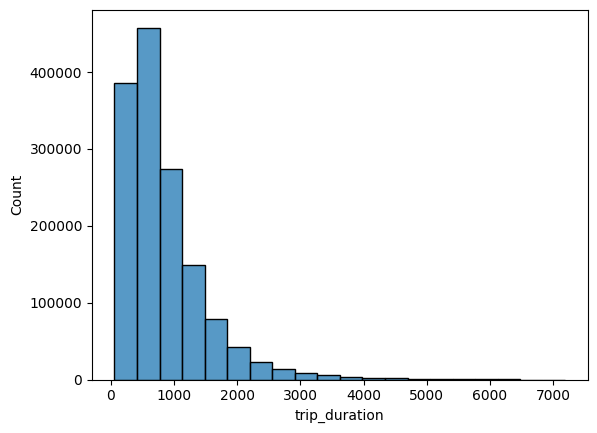

In [32]:
filtered_duration = train_data[train_data["trip_duration"].between(60, 7200)]

sns.histplot(data=filtered_duration, x="trip_duration", bins=20)
plt.show()

Looking at the filtered data above, although the data is still moderately skewed, the durations are now within a more realistic range of values.

In [27]:
# Count how many rows are affected
unrealistic_durations = len(train_data[(train_data["trip_duration"] < 1) | (train_data["trip_duration"] > 7200)])

print(f"Number of rows affected: {unrealistic_durations:,}")
print(f"Proportion of data: {unrealistic_durations / len(train_data) * 100:.2f}%")

Number of rows affected: 2,253
Proportion of data: 0.15%


To find out of range taxi trips, [Wikipedia](https://en.wikipedia.org/wiki/Module:Location_map/data/USA_New_York_City) provided the following border coordinates for NYC:

- top = 40.92
- bottom = 40.49
- left = -74.27
- right = -73.68

In [41]:
# NYC boundary coordinates
lat_top = 40.92
lat_bot = 40.49
long_left = -74.27
long_right = -73.68

# Define condition for coordinates within NYC area
outside_nyc_bounds = ~(
    train_data['pickup_latitude'].between(lat_bot, lat_top) &
    train_data['dropoff_latitude'].between(lat_bot, lat_top) &
    train_data['pickup_longitude'].between(long_left, long_right) &
    train_data['dropoff_longitude'].between(long_left, long_right)
)

# Check for out of range pickup and dropoff coordinates
out_of_nyc_trips = len(train_data[outside_nyc_bounds])
print(f"Number of rows affected: {out_of_nyc_trips:,}")
print(f"Proportion of data: {out_of_nyc_trips / len(train_data) * 100:.2f}%")

Number of rows affected: 1,211
Proportion of data: 0.08%


### Outliers

In [16]:
# Check for outliers


## Fixing the Issues

In [42]:
# Store cleaned data into a new dataframe
train_data_clean = train_data.copy()

# Remove irrelevant features
irrelevant_cols = ["id", "dropoff_datetime", "store_and_fwd_flag"]
train_data_clean = train_data_clean.drop(columns=irrelevant_cols)

# Cast the following columns to appropriate data type
train_data_clean["vendor_id"] = train_data_clean["vendor_id"].astype("category")
train_data_clean["pickup_datetime"] = pd.to_datetime(train_data_clean["pickup_datetime"], errors="coerce")

# Subset the following columns to realistic ranges
train_data_clean = train_data_clean[train_data_clean["passenger_count"].between(1, 5)] # 1-5 passengers only
train_data_clean = train_data_clean[train_data_clean["trip_duration"].between(60, 7200)] # durations from 1min to 2hrs only

# Remove records that are outside NYC boundaries
in_nyc_bounds = (
    train_data_clean['pickup_latitude'].between(lat_bot, lat_top) &
    train_data_clean['dropoff_latitude'].between(lat_bot, lat_top) &
    train_data_clean['pickup_longitude'].between(long_left, long_right) &
    train_data_clean['dropoff_longitude'].between(long_left, long_right)
)

train_data_clean = train_data_clean[in_nyc_bounds]

train_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1398726 entries, 0 to 1458643
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   vendor_id          1398726 non-null  category      
 1   pickup_datetime    1398726 non-null  datetime64[ns]
 2   passenger_count    1398726 non-null  int64         
 3   pickup_longitude   1398726 non-null  float64       
 4   pickup_latitude    1398726 non-null  float64       
 5   dropoff_longitude  1398726 non-null  float64       
 6   dropoff_latitude   1398726 non-null  float64       
 7   trip_duration      1398726 non-null  int64         
dtypes: category(1), datetime64[ns](1), float64(4), int64(2)
memory usage: 86.7 MB


In [43]:
train_data_clean.head()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
0,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,455
1,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,663
2,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,2124
3,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,429
4,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,435


# Feature Engineering

# Exploratory Data Analysis

## Descriptive Statistics

## Univariate Analysis

## Bivariate Analysis

## Summary of Insights

- c

# Data Preprocessing

# Modeling

- Model Selection
- Training
- Evaluation
- Hyperparameter Tuning
- Saving Best Model

# Generating Predictions

# Conclusions and Recommendations

- c